<a href="https://colab.research.google.com/github/vilhohelenius/dippatyo/blob/main/tabpfn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tabpfn
from tabpfn import TabPFNRegressor

df = pd.read_csv("/content/df_ml.csv", index_col=0)

# Target and features
y = df["bmi"].values
X = df.drop(columns=["bmi"]).values

print("Samples:", X.shape[0])
print("Features:", X.shape[1])

# Train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

# Initialize and fit
model = TabPFNRegressor(device="auto")
model.fit(X_train, y_train)

# Predict
preds = model.predict(X_test)



Samples: 9625
Features: 210


tabpfn-v2.5-regressor-v2.5_default.ckpt:   0%|          | 0.00/40.8M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

In [3]:
from sklearn.metrics import root_mean_squared_error

# Evaluate
print("RMSE:", root_mean_squared_error(y_test, preds))
print("MSE:", mean_squared_error(y_test, preds))
print("MAE:", mean_absolute_error(y_test, preds))
print("R²:", r2_score(y_test, preds))

RMSE: 4.5208363853333475
MSE: 20.43796162295389
MAE: 3.2970746352911453
R²: 0.24707621454963347


In [4]:
import joblib
from pathlib import Path

# Create directory
Path("results/tabpfn").mkdir(parents=True, exist_ok=True)

# Save model
joblib.dump(model, "results/tabpfn/model.pkl")



['results/tabpfn/model.pkl']

In [5]:
model = joblib.load("results/tabpfn/model.pkl")

In [6]:
import numpy as np

pred_df = pd.DataFrame({
    "sample_id": np.arange(len(y_test)),
    "y_true": y_test,
    "y_pred": preds
})

# Save predictions
pred_df.to_csv("results/tabpfn/predictions.csv", index=False)

In [7]:
import json
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error

metrics = {
    "R2": float(r2_score(y_test, preds)),
    "RMSE": float(root_mean_squared_error(y_test, preds)),
    "MSE": float(mean_squared_error(y_test, preds)),
    "MAE": float(mean_absolute_error(y_test, preds))
}

# Save metrics
with open("results/tabpfn/metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

In [8]:
metadata = {
    "model": "TabPFNRegressor",
    "device": "auto",
    "random_state": 42,
    "train_size": len(X_train),
    "test_size": len(X_test),
    "n_features": X_train.shape[1],
    "tabpfn_version": "v1",
}

# Save metadata
with open("results/tabpfn/metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)

In [9]:
model = joblib.load("results/tabpfn/model.pkl")
pred_df = pd.read_csv("results/tabpfn/predictions.csv")


with open("results/tabpfn/metrics.json") as f:
    metrics = json.load(f)

In [10]:
feature_names = pd.read_csv(
    "/content/feature_names.csv",
    header=None
)[0].tolist()

In [12]:
feature_names.pop(0)


'x'

PermutationExplainer explainer: 51it [2:44:26, 197.34s/it]


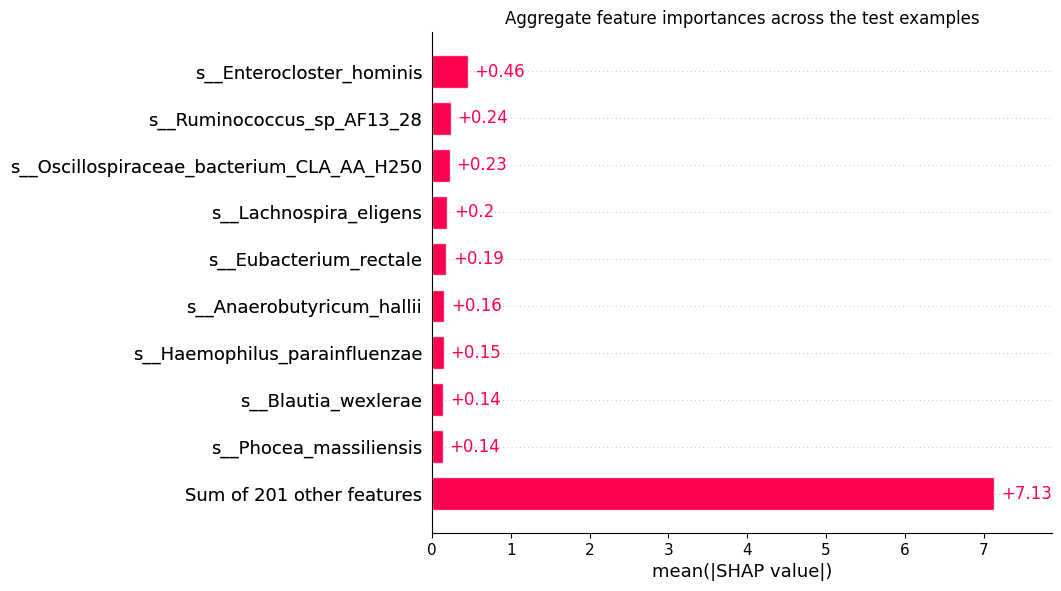

/usr/local/lib/python3.12/dist-packages/tabpfn_extensions/interpretability/shap.py:137: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values=shap_values, show=False)


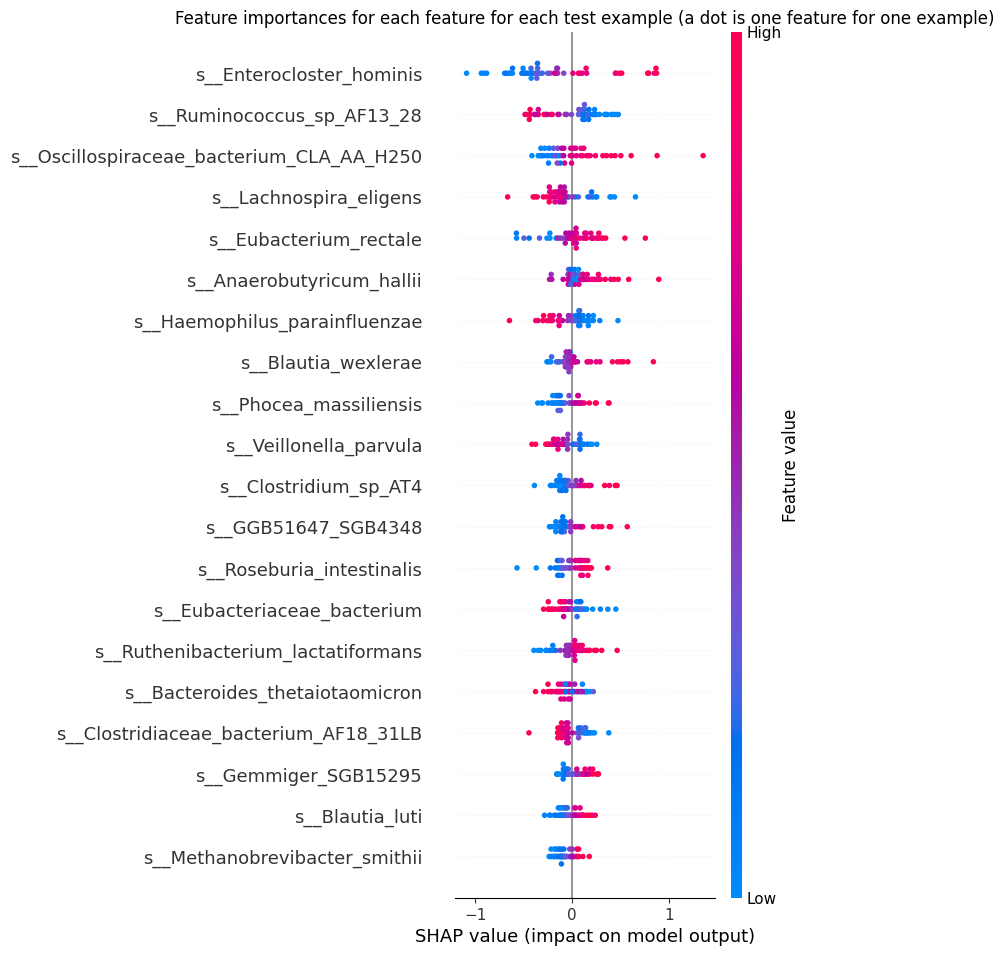

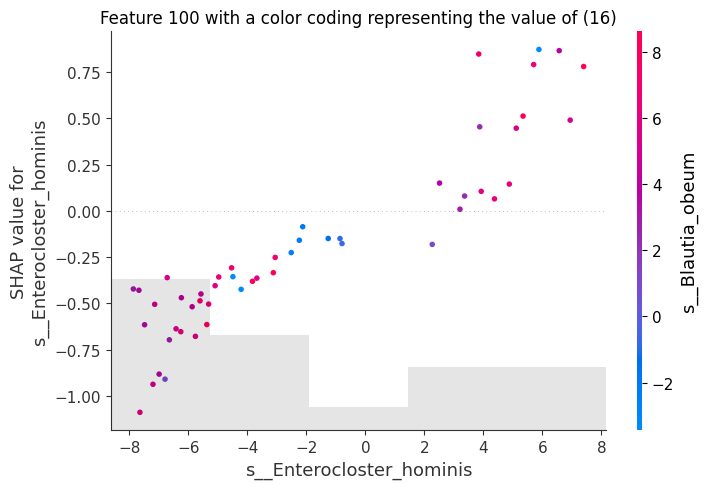

In [13]:
from tabpfn_extensions import interpretability
import matplotlib.pyplot as plt

# Calculate SHAP values
shap_values = interpretability.shap.get_shap_values(
    estimator=model,
    test_x=X_test[:50],
    attribute_names=feature_names,
    algorithm="permutation",
)

# Create visualization of SHAP values

fig = interpretability.shap.plot_shap(shap_values)
plt.tight_layout()
plt.show()




In [14]:
import numpy as np

# Mean absolute SHAP per feature
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

shap_df = pd.DataFrame({
    "feature": feature_names,
    "mean_abs_shap": mean_abs_shap
}).sort_values("mean_abs_shap", ascending=False)

# Top 20
shap_top20 = shap_df.head(20)
shap_top20

# Save
shap_top20.to_csv("results/tabpfn/shap_top20.csv", index=False)

In [19]:
shap_signed = pd.DataFrame(
    shap_values.values,
    columns=feature_names
)

# Correlation between SHAP value and feature value
direction_df = []

for feat in shap_top20["feature"]:
    feat_idx = feature_names.index(feat)
    corr = np.corrcoef(
        shap_signed[feat],
        X_test[:50, feat_idx]
    )[0, 1]
    direction_df.append((feat, corr))

direction_df = pd.DataFrame(
    direction_df,
    columns=["feature", "direction"]
)

direction_df

,feature,direction
0,s__Enterocloster_hominis,0.920268
1,s__Ruminococcus_sp_AF13_28,-0.931549
2,s__Oscillospiraceae_bacterium_CLA_AA_H250,0.828342
3,s__Lachnospira_eligens,-0.937106
4,s__Eubacterium_rectale,0.860416
5,s__Anaerobutyricum_hallii,0.622331
6,s__Haemophilus_parainfluenzae,-0.932501
7,s__Blautia_wexlerae,0.810267
8,s__Phocea_massiliensis,0.941844
9,s__Veillonella_parvula,-0.961139


In [20]:
joblib.dump(shap_df, "results/tabpfn/shap_full.pkl")

['results/tabpfn/shap_full.pkl']